In [1]:
import torch
print(torch.__version__)

2.5.0+cu121


In [2]:
!python --version

Python 3.10.12


# <font color = 'indianred'>**Multilabel Classification of StackExchange Dataset using DistilBert** </font>

**Objective:**

In this notebook, we aim to build the base model without accounting for the data imbalance. We will learn how the label imbalance can influence our results.


**Plan**

1. Set Environment
2. Load Dataset
3. Accessing and Manipulating Splits
4. Load Pre-trained Tokenizer
5. Create Function for Tokenizer
4. Train Model
  1. Download pre-trained model <br>
  2. Download and modify the model config file <br>
  3. Compute Metric Function <br>
  4. Training Arguments <br>
  5. Instantiate Trainer <br>
  6. Setup WandB <br>
  7. Training and Validation
6. Perfromance on Test Set
7. Model Inference






















# <font color = 'indianred'> **1. Setting up the Environment** </font>



In [3]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  # !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate -U peft bitsandbytes  ## NEW LINES ##
  basepath = '/content/drive/MyDrive/data/'
else:
  basepath = '/home/harpreet/Insync/google_drive_shaannorr/data'

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Un

<font color = 'indianred'> *Load Libraries* </font>

In [4]:
!apt-get install -y ninja-build

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  ninja-build
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 111 kB of archives.
After this operation, 358 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 ninja-build amd64 1.10.1-1 [111 kB]
Fetched 111 kB in 0s (567 kB/s)
Selecting previously unselected package ninja-build.
(Reading database ... 123622 files and directories currently installed.)
Preparing to unpack .../ninja-build_1.10.1-1_amd64.deb ...
Unpacking ninja-build (1.10.1-1) ...
Setting up ninja-build (1.10.1-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [5]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import gc
import time

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import joblib

import torch
import torch.nn as nn
import ast


# New libraries introduced in this notebook
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    set_seed,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
    DataCollatorWithPadding
)
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

import wandb
from google.colab import userdata
from huggingface_hub import login


In [6]:
set_seed(42)

In [7]:
wandb_api_key = userdata.get('WANDB_API_KEY')
hf_token = userdata.get('HF_TOKEN')


In [8]:
if hf_token:
    # Log in to Hugging Face
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("Hugging Face token not found in notebook secrets.")


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
Successfully logged in to Hugging Face!


In [9]:
if wandb_api_key:
  wandb.login(key=wandb_api_key)
  print("Successfully logged in to WANDB!")
else:
    print("WANDB key not found in notebook secrets.")


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Successfully logged in to WANDB!


In [10]:
# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS
base_folder = Path(basepath)
data_folder = base_folder/'datasets/Classification_HW/joblib_files'

# <font color = 'indianred'> **2. Load Data set**
    


In [11]:
df = joblib.load(data_folder/'df_multilabel_hw_cleaned.joblib')
df

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"
...,...,...,...
47422,take value edittext put decimal point all- wor...,java android,"[1, 4]"
47423,listen phone state application nee liste phone...,java android,"[1, 4]"
47424,android ui thread thread task want access main...,java android,"[1, 4]"
47425,dynamic table row creation html javascript htm...,asp.net javascript,"[9, 3]"


In [12]:
stack_dataset = Dataset.from_pandas(df)

In [13]:
selected_columns = {
    'text': stack_dataset['cleaned_text'],
    'tag': stack_dataset['Tag_Number']
}

# Create a new dataset with the selected columns
stack_selected_columns = Dataset.from_dict(selected_columns)

In [14]:
# Set the format to Pandas
stack_selected_columns.set_format(type='pandas')

In [15]:
df = stack_selected_columns[:]

In [16]:
df['tag_mod'] = df['tag'].apply(lambda x: ast.literal_eval(x))

In [17]:
label_encoder = MultiLabelBinarizer()

In [18]:
df['label'] = list(label_encoder.fit_transform(df['tag_mod']))

In [19]:
df_final = df[['text', 'label']]

In [20]:
class_names = ['c#', 'java', 'php','javascript', 'android', 'jquery', 'c++',  'python', 'iphone', 'asp.net']

In [21]:
stack_selected_columns_final = Dataset.from_pandas(df_final)

# <font color = 'indianred'> **3. Accessing and Manuplating Splits**</font>



<font color = 'indianred'>*Create futher subdivions of the splits*</font>

In [22]:
# Split the test set into test and validation sets
test_val_splits = stack_selected_columns_final.train_test_split(test_size=0.4, seed=42)
train_split= test_val_splits['train']
test_val_splits = test_val_splits['test'].train_test_split(test_size=0.5, seed=42,)
val_split = test_val_splits['train']
test_split = test_val_splits['test']


<font color = 'indianred'>*small subset for initial experimenttaion*</font>

In [23]:
train_split = train_split.shuffle(seed = 42).select(range(2000))
val_split = val_split.shuffle(seed = 42).select(range(2000))
test_split = test_split.shuffle(seed = 42).select(range(2000))

In [24]:
train_val_subset= DatasetDict(
    {"train": train_split, "valid": val_split})

In [25]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [26]:
train_val_subset['train']['label'][0]

[0, 0, 0, 1, 0, 1, 0, 0, 0, 0]

# <font color = 'indianred'>**4. Load pre-trained Tokenizer**</font>



In [27]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")


In [28]:
free_gpu_memory()

GPU memory has been freed.


In [29]:
checkpoint = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

#<font color = 'indianred'> **5. Create function for Tokenizer**



In [30]:
tokenizer.pad_token = '<|finetune_right_pad_id|>'

In [31]:
# tokenizer

In [32]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True, max_length=512)

<font color = 'indianred'> *Use map function to apply tokenization to all splits*

In [33]:
tokenized_dataset= train_val_subset.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [34]:
tokenized_dataset = (tokenized_dataset
          .map(lambda x : {"float_label": x["label"].to(torch.float)}, remove_columns=["label"])
          .rename_column("float_label", "label"))

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [35]:
tokenized_dataset['train']['label'][0:3]

tensor([[0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.]])

#  <font color = 'indianred'> **6. Model Training**

##  <font color = 'indianred'> **6.1 Download pre-trained model**

In [36]:
def get_appropriate_dtype():
    if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
        return torch.bfloat16
    return torch.float16

In [37]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.bfloat16

In [38]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch_data_type,
  bnb_4bit_quant_storage=torch_data_type,
)

In [39]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 10,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,)


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##  <font color = 'indianred'> **6.2 Downaload and Modify Model Config File**

In [40]:
config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
config.id2label = id2label
config.label2id = label2id
model.config = config
model.config.pad_token_id = tokenizer.pad_token_id

##  <font color = 'indianred'> **6.3 PEFT Setup**

In [41]:
model

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((20

In [42]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [43]:
find_linear_layers(model)

['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'score']


['k_proj',
 'o_proj',
 'v_proj',
 'down_proj',
 'q_proj',
 'score',
 'gate_proj',
 'up_proj']

In [44]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    bias="all",
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

lora_model = get_peft_model(model, peft_config )
# qlora_model.resize_token_embeddings(len(tokenizer))
lora_model.print_trainable_parameters()

trainable params: 90,198,016 || all params: 1,326,032,896 || trainable%: 6.8021


In [45]:
lora_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
         

In [46]:
for name, param in lora_model.named_parameters():
    print(f"{name}: {param.requires_grad}")


base_model.model.model.embed_tokens.weight: False
base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight: False
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight: True
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight: True
base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight: False
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight: True
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight: True
base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight: False
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight: True
base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight: True
base_model.model.model.layers.0.self_attn.o_proj.base_layer.weight: False
base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight: True
base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight: True
base_model.model.model.layers.0.mlp.ga

##  <font color = 'indianred'> **6.4 compute_metrics function** </font>



In [47]:
# load training metrices
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    preds = (logits > 0).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}


## <font color = 'indianred'> **6.4 Training Arguments**</font>







In [48]:
# Define the directory where model checkpoints will be saved
model_folder = Path("/content/llama_lora_imb")
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
run_name= 'stack_exp_imb_exp1'

use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16

# Configure training parameters
training_args = TrainingArguments(
    seed = 42,
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant":False},
    # torch_empty_cache_steps=5,
    weight_decay=0.0,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases

    # Precision settings determined based on GPU capability
    fp16=use_fp16 ,  # Set True if torch_data_type is torch.float16
    bf16=use_bf16,  # Set True if torch_data_type is torch.bfloat16
    tf32=False,  # Disable tf32 unless you want to use Ampere specific optimization
)


In [49]:
# If gradient checkpointing is enabled, configure relevant settings
if training_args.gradient_checkpointing:
    lora_model.config.use_cache = False  # Disable caching for compatibility

lora_model.config

LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "id2label": {
    "0": "c#",
    "1": "java",
    "2": "php",
    "3": "javascript",
    "4": "android",
    "5": "jquery",
    "6": "c++",
    "7": "python",
    "8": "iphone",
    "9": "asp.net"
  },
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "label2id": {
    "android": 4,
    "asp.net": 9,
    "c#": 0,
    "c++": 6,
    "iphone": 8,
    "java": 1,
    "javascript": 3,
    "jquery": 5,
    "php": 2,
    "python": 7
  },
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor"

##  <font color = 'indianred'> **6.5 Initialize Trainer**</font>



In [50]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['label'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['label']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

In [51]:
pos_weights = calculate_pos_weights(tokenized_dataset)

In [52]:
pos_weights

tensor([  3.3290,   4.7637,   7.4388,   0.7422,   5.5789,   0.8939,  59.6061,
        132.3333, 180.8182,   2.7594])

In [53]:
# initialize trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [54]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [55]:
# lora_model.config.use_cache = False
trainer = CustomTrainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator
)

<ipython-input-55-205d00a764b3>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


## <font color = 'indianred'> **6.6 Setup WandB**</font>

In [56]:
%env WANDB_PROJECT = multilabel_stack

env: WANDB_PROJECT=multilabel_stack


##  <font color = 'indianred'> **6.7 Training and Validation**

In [57]:
try:
    # Your code that may cause a CUDA out-of-memory error
    # Example: trainer.train() or other GPU intensive operations
    # lora_model.config.use_cache = False
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("CUDA out of memory error detected. Freeing GPU memory.")
        free_gpu_memory()
        # Optionally, you can retry the operation here after freeing up memory
        # Example retry:
        # trainer.train()
    else:
        raise e


wandb: Currently logged in as: hsingh-utd. Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy Label,Accuracy All
20,1.552900,1.723629,0.440450,0.295799,0.671600,0.012000
40,1.650700,1.467394,0.517963,0.353454,0.784650,0.140500
60,1.212300,1.155532,0.681818,0.502774,0.844600,0.213500
80,0.734600,1.121645,0.802653,0.595785,0.910750,0.535000
100,0.782100,1.134412,0.833508,0.622425,0.928550,0.639500
120,0.738500,1.146742,0.833446,0.630453,0.926200,0.621000
140,0.619400,0.947191,0.865658,0.672228,0.943200,0.691000
160,0.241500,0.917342,0.867692,0.691957,0.943200,0.683500
180,0.933400,0.840462,0.860051,0.698065,0.939500,0.664000
200,0.444200,0.709222,0.865133,0.713941,0.941650,0.666000


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at ../aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered i

<font color = 'indianred'> *Evaluate model on Validation Set* </font>


In [58]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [59]:
eval_results

{'eval_loss': 0.675723135471344,
 'eval_f1_micro': 0.8745238370079649,
 'eval_f1_macro': 0.7345282149105763,
 'eval_accuracy_label': 0.94565,
 'eval_accuracy_all': 0.685,
 'eval_runtime': 20.9287,
 'eval_samples_per_second': 95.562,
 'eval_steps_per_second': 3.01,
 'epoch': 2.0}

In [60]:
wandb.log({"eval_f1_macro": eval_results["eval_f1_macro"], "eval_loss": eval_results["eval_loss"], "eval_accuracy": eval_results["eval_accuracy_all"]})

<font color = 'indianred'> *Finetune threshold* </font>

In [61]:
from scipy.special import expit as sigmoid
valid_output = trainer.predict(tokenized_dataset["valid"])

# Get probabilities from logits
valid_logits = valid_output.predictions
valid_probs = sigmoid(valid_logits)
valid_labels = np.array(valid_output.label_ids.astype(int))

In [62]:
valid_logits.shape

(2000, 10)

In [63]:
valid_probs.shape

(2000, 10)

In [64]:
valid_labels.shape

(2000, 10)

In [65]:
def find_best_thresholds_multilabel(probabilities, labels):
    """
    Find best threshold for each label that maximizes F1 score

    Args:
        probabilities: Array of shape (n_samples, n_labels) with predicted probabilities
        labels: Array of shape (n_samples, n_labels) with true binary labels

    Returns:
        thresholds: List of best thresholds for each label
        metrics: Dictionary containing best F1, precision, and recall for each label
    """
    n_labels = labels.shape[1]
    best_thresholds = []
    metrics = {}

    for label_idx in range(n_labels):
        # Get scores and labels for this label
        label_scores = probabilities[:, label_idx]
        label_true = labels[:, label_idx]

        # Sort by scores
        rows = list(zip(label_scores, label_true))
        rows = sorted(rows, key=lambda x: x[0], reverse=True)

        # Initialize metrics
        best_f1 = best_precision = best_recall = 0
        threshold = 0

        # Count total positives for this label
        total_positives = sum(label_true)

        # Initialize counters
        total_predicted_positives = 0
        true_positives = 0

        # print(f"\nAnalyzing label {label_idx}")

        # Try different thresholds
        for i in range(len(rows) - 1):
            score, label = rows[i]
            total_predicted_positives += 1
            if label == 1:
                true_positives += 1

            if true_positives > 0:
                precision = true_positives / total_predicted_positives
                recall = true_positives / total_positives
                f1 = 2 * precision * recall / (precision + recall)

                # Update best metrics if current F1 is better
                if f1 > best_f1:
                    best_f1 = f1
                    best_precision = precision
                    best_recall = recall
                    threshold = (rows[i][0] + rows[i + 1][0]) / 2

                    # print(f"New best threshold found: {threshold:.3f}")
                    # print(f"F1: {best_f1:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")

        best_thresholds.append(threshold)
        metrics[label_idx] = {
            'f1': best_f1,
            'precision': best_precision,
            'recall': best_recall,
            'threshold': threshold
        }


    return best_thresholds, metrics



In [66]:
optimal_thresholds, metrics = find_best_thresholds_multilabel(valid_probs, valid_labels)


In [67]:
optimal_thresholds

[0.7256485819816589,
 0.7937454581260681,
 0.793105959892273,
 0.4667241871356964,
 0.8683803081512451,
 0.6641045808792114,
 0.7177223563194275,
 0.33285456895828247,
 0.38052892684936523,
 0.8407797813415527]

In [68]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics(eval_pred, thresholds):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > thresholds).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}

In [69]:
compute_metrics((valid_logits, valid_labels), optimal_thresholds)

{'f1_micro': 0.8841801107633036,
 'f1_macro': 0.7584879671487799,
 'accuracy_label': 0.9519,
 'accuracy_all': 0.721}

<font color = 'indianred'> *Confusion Matrix*</font>

In [70]:
valid_preds = (valid_probs > optimal_thresholds).astype(int)
mcm = multilabel_confusion_matrix(valid_labels, valid_preds)
print(mcm)

[[[1465   91]
  [  91  353]]

 [[1642   27]
  [  32  299]]

 [[1743   36]
  [  55  166]]

 [[ 689  125]
  [  87 1099]]

 [[1688    6]
  [  35  271]]

 [[ 851   78]
  [  76  995]]

 [[1957    9]
  [   5   29]]

 [[1948   28]
  [  12   12]]

 [[1956   30]
  [   7    7]]

 [[1427   38]
  [  94  441]]]


In [71]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats


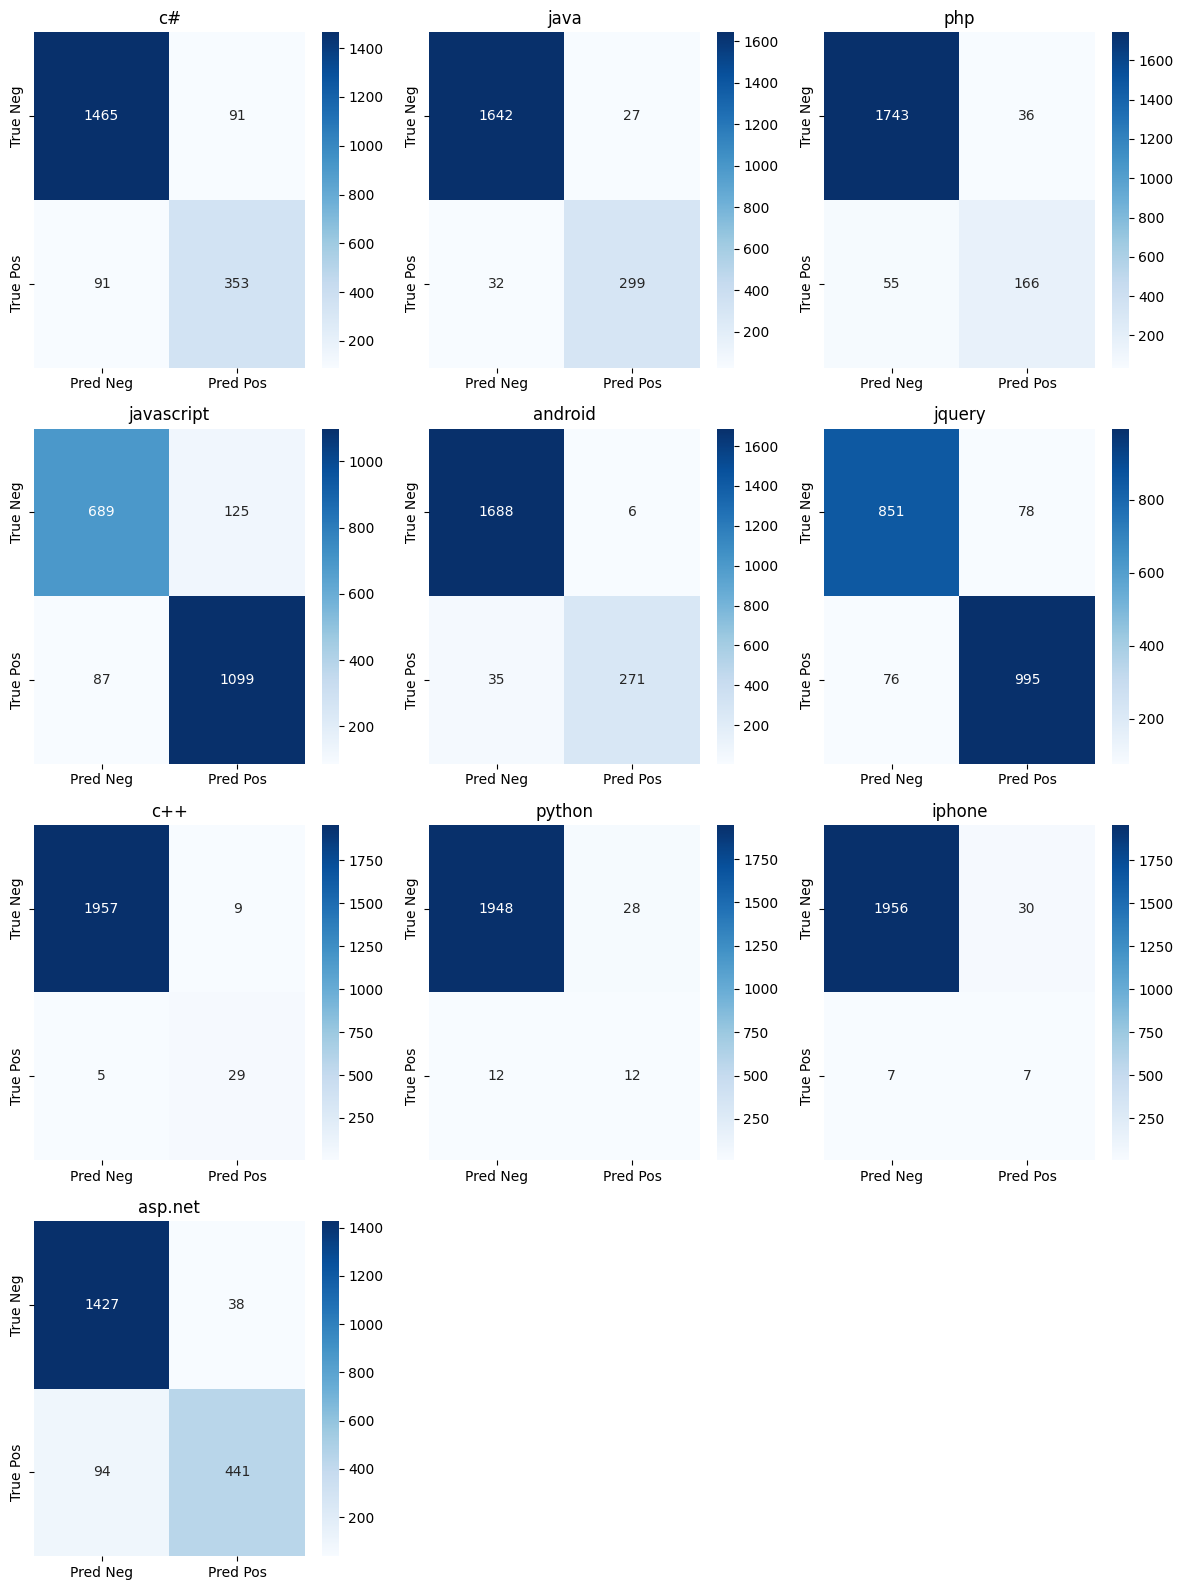

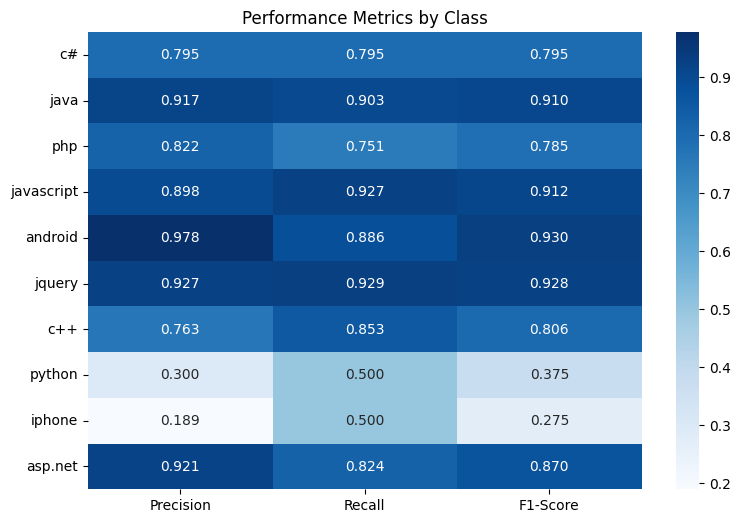

<Figure size 1200x533.333 with 0 Axes>

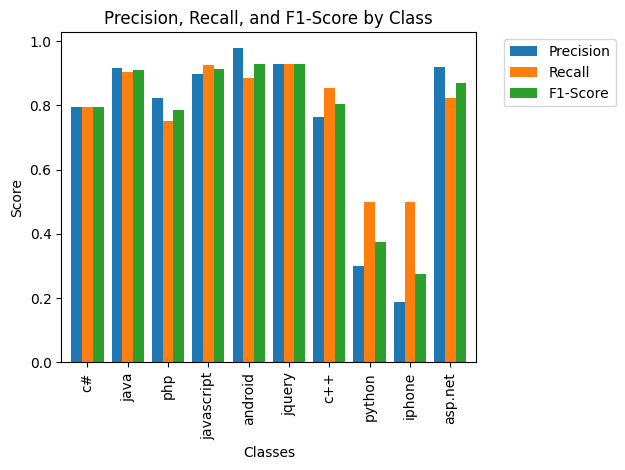

{'macro_avg': {'precision': 0.7510542063890202,
  'recall': 0.7868043150632457,
  'f1': 0.7584879671487799},
 'per_class': {'Precision': {'c#': 0.795045045045045,
   'java': 0.9171779141104295,
   'php': 0.8217821782178217,
   'javascript': 0.8978758169934641,
   'android': 0.9783393501805054,
   'jquery': 0.9273066169617894,
   'c++': 0.7631578947368421,
   'python': 0.3,
   'iphone': 0.1891891891891892,
   'asp.net': 0.9206680584551148},
  'Recall': {'c#': 0.795045045045045,
   'java': 0.9033232628398792,
   'php': 0.751131221719457,
   'javascript': 0.9266441821247892,
   'android': 0.8856209150326797,
   'jquery': 0.9290382819794585,
   'c++': 0.8529411764705882,
   'python': 0.5,
   'iphone': 0.5,
   'asp.net': 0.8242990654205608},
  'F1-Score': {'c#': 0.795045045045045,
   'java': 0.9101978691019786,
   'php': 0.7848699763593381,
   'javascript': 0.9120331950207469,
   'android': 0.9296740994854202,
   'jquery': 0.9281716417910447,
   'c++': 0.8055555555555556,
   'python': 0.375

In [72]:
multilabel_evaluation(y_true=valid_labels, y_pred=valid_preds, class_names=class_names, figsize=(12, 8))

<font color = 'indianred'> *Get best checkpoint*</font>


In [73]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")


The best model was saved at step 220.


#  <font color = 'indianred'> **7. Performance on Test Set** </font>
For test set evaluation, we will perfrom following steps:



In [74]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/llama_lora_imb/checkpoint-220'

In [75]:
from peft import AutoPeftModelForSequenceClassification, PeftConfig

In [85]:
model = AutoPeftModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 10,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,
)

peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = '<|finetune_right_pad_id|>'

# 3. Set model to evaluation mode
model.eval()
model.config.use_cache = False
model.config.pad_token_id = tokenizer.pad_token_id
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
model.config.id2label = id2label
model.config.label2id = label2id


`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [86]:
test_set_tokenized = test_split.map(tokenize_fn, batched=True)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [87]:
test_set_tokenized

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2000
})

In [88]:
test_set_tokenized.set_format(type='torch')
test_set_tokenized = (test_set_tokenized
          .map(lambda x : {"float_label": x["label"].to(torch.float)}, remove_columns=["label"])
          .rename_column("float_label", "label"))

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

<font color = 'indianred'>*Training Arguments*</font>

In [89]:
training_args = TrainingArguments(
    seed = 42,
    output_dir="./results",
    per_device_eval_batch_size=128,
    do_train=False,
    do_eval=True,
    report_to=[],
    run_name=run_name
)

<font color = 'indianred'>*Instantiate Trainer*</font>

In [90]:
from functools import partial

In [91]:
compute_metrics_fn = partial(compute_metrics, thresholds=optimal_thresholds)

In [92]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    eval_dataset=test_set_tokenized,
    compute_metrics=compute_metrics_fn,
    tokenizer=tokenizer,
)

<ipython-input-92-b7cbf9c7164a>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


<font color = 'indianred'>*Evaluate using Trainer*</font>

In [93]:
test_results= trainer.evaluate()

In [94]:
test_results

{'eval_loss': 0.535520613193512,
 'eval_model_preparation_time': 0.0047,
 'eval_f1_micro': 0.8760111070868043,
 'eval_f1_macro': 0.7407556300098463,
 'eval_accuracy_label': 0.94865,
 'eval_accuracy_all': 0.7085,
 'eval_runtime': 21.8477,
 'eval_samples_per_second': 91.543,
 'eval_steps_per_second': 0.732}

In [95]:
wandb.log({"test_f1_macro": test_results["eval_f1_macro"], "test_loss": test_results["eval_loss"], "test_accuracy": test_results["eval_accuracy_all"]})

<font color = 'indianred'>*Confusion Matrix*</font>

In [96]:
test_output = trainer.predict(test_set_tokenized)

In [97]:
test_preds = np.array((test_output.predictions > 0).astype(int))
test_labels = np.array(test_output.label_ids.astype(int))


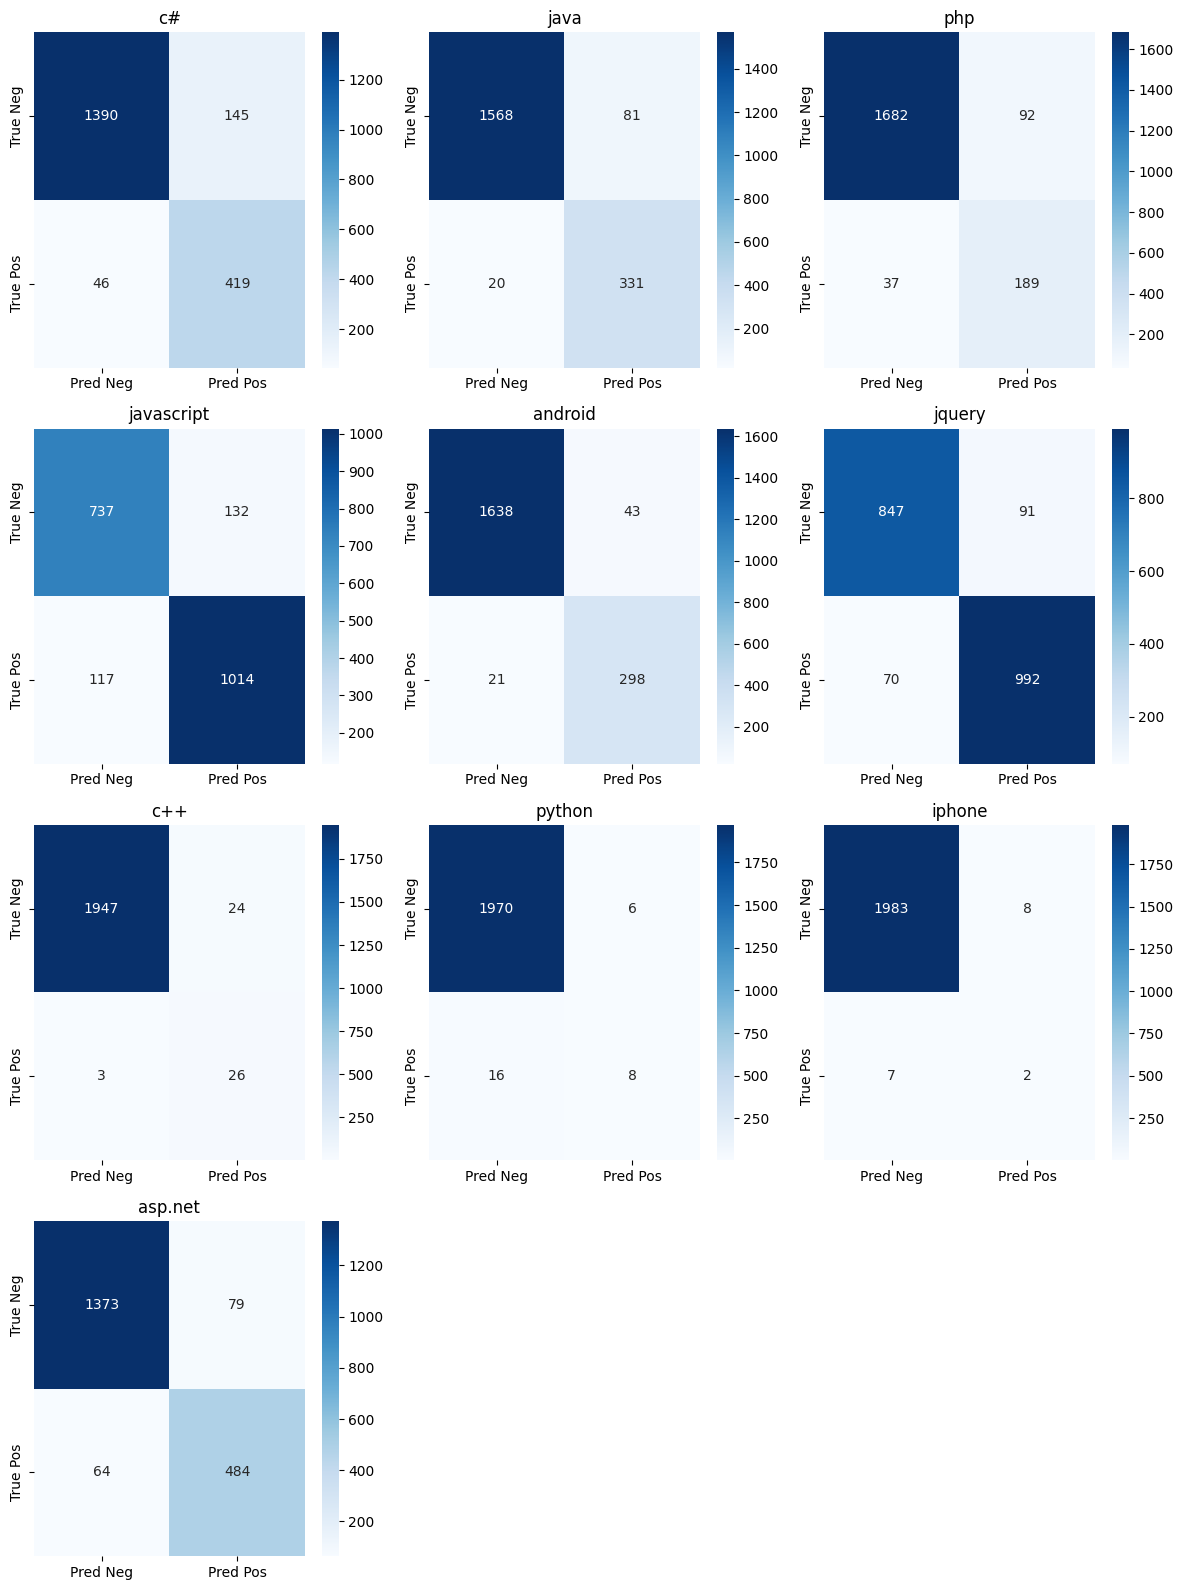

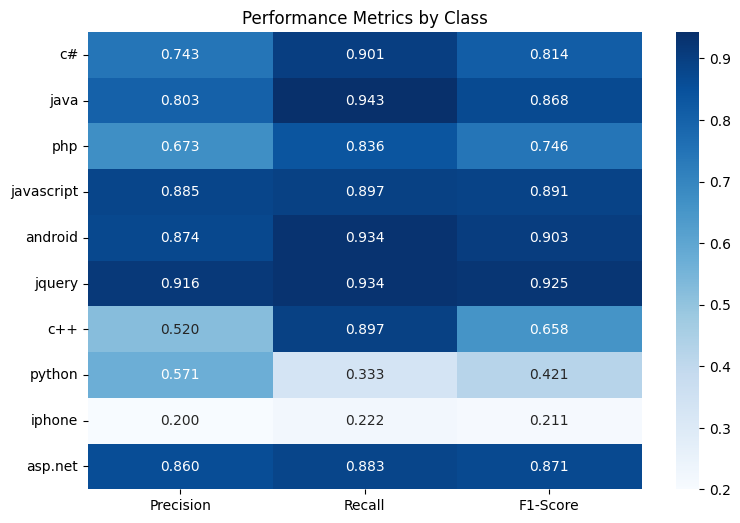

<Figure size 1200x533.333 with 0 Axes>

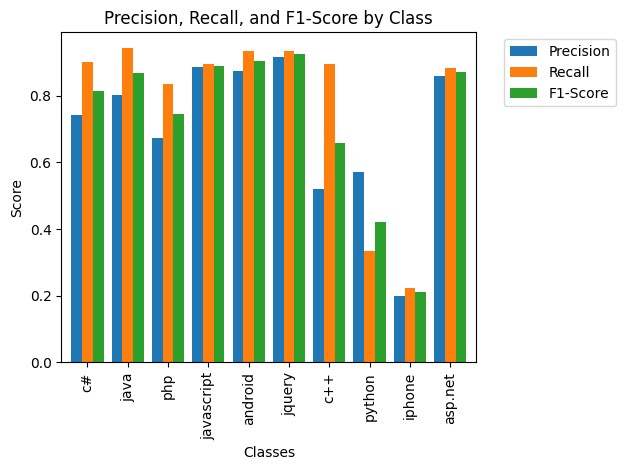

{'macro_avg': {'precision': 0.7044703773132828,
  'recall': 0.7780504988340138,
  'f1': 0.7307284349704387},
 'per_class': {'Precision': {'c#': 0.7429078014184397,
   'java': 0.8033980582524272,
   'php': 0.6725978647686833,
   'javascript': 0.8848167539267016,
   'android': 0.873900293255132,
   'jquery': 0.9159741458910434,
   'c++': 0.52,
   'python': 0.5714285714285714,
   'iphone': 0.2,
   'asp.net': 0.8596802841918295},
  'Recall': {'c#': 0.9010752688172043,
   'java': 0.9430199430199431,
   'php': 0.8362831858407079,
   'javascript': 0.896551724137931,
   'android': 0.9341692789968652,
   'jquery': 0.9340866290018832,
   'c++': 0.896551724137931,
   'python': 0.3333333333333333,
   'iphone': 0.2222222222222222,
   'asp.net': 0.8832116788321168},
  'F1-Score': {'c#': 0.814382896015549,
   'java': 0.8676277850589778,
   'php': 0.7455621301775148,
   'javascript': 0.8906455862977603,
   'android': 0.9030303030303031,
   'jquery': 0.924941724941725,
   'c++': 0.6582278481012658,
   

In [98]:
multilabel_evaluation(y_true=test_labels, y_pred=test_preds, class_names=class_names, figsize=(12, 8))

In [99]:
wandb.finish()

eval/accuracy_all,▁▂▃▆▇▇███████
eval/accuracy_label,▁▄▅▇█████████
eval/f1_macro,▁▂▄▆▆▆▇▇▇████
eval/f1_micro,▁▂▅▇▇▇███████
eval/loss,█▆▄▄▄▄▃▃▂▁▁▁▁
eval/runtime,█▁▁▁▁▁▁▁▁▁▁▁▁
eval/samples_per_second,▁████████████
eval/steps_per_second,▁████████████
eval_accuracy,▁
eval_f1_macro,▁
eval_loss,▁


# <Font color = 'indianred'> **8. Model Inference**



In [106]:
model = AutoPeftModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 10,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,
)

peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = '<|finetune_right_pad_id|>'

# 3. Set model to evaluation mode
model.eval()
model.config.use_cache = False
model.config.pad_token_id = tokenizer.pad_token_id
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
model.config.id2label = id2label
model.config.label2id = label2id

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [107]:
custom_pipeline = pipeline(
    task="text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    function_to_apply='sigmoid')

The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForSequenceClassification', 'ErnieForSequenceClassification', 'ErnieMForSequenceClassification', 'EsmForSequenceClassification', 'FalconForSequenceClassification', 'FlaubertForSequenceClassification', 'FNetForSequenceClassification', 'FunnelForSequenceClassification', 'GemmaForSequenceClassification'

<font color = 'indianred'> **Test the pipeline on a single example**

In [108]:
sample = test_split['text'][0]
preds = custom_pipeline(sample)
preds


[[{'label': 'c#', 'score': 0.04401864856481552},
  {'label': 'java', 'score': 0.9995272159576416},
  {'label': 'php', 'score': 0.020645931363105774},
  {'label': 'javascript', 'score': 0.004609572235494852},
  {'label': 'android', 'score': 0.9996199607849121},
  {'label': 'jquery', 'score': 0.001367025775834918},
  {'label': 'c++', 'score': 0.004609572235494852},
  {'label': 'python', 'score': 0.09401018172502518},
  {'label': 'iphone', 'score': 0.005384938325732946},
  {'label': 'asp.net', 'score': 0.055005285888910294}]]

In [109]:
def get_positive_labels(pipeline_output, optimal_thresholds):

   positive_labels = []

   for pred_set in pipeline_output:
       # Get scores for all labels
       scores = [pred['score'] for pred in pred_set]
       labels = [pred['label'] for pred in pred_set]

       # Get positions where score > threshold for that label
       sample_positives = [
           label for label, score, threshold in zip(labels, scores, optimal_thresholds)
           if score >= threshold
       ]

       positive_labels.append(sample_positives)

   return positive_labels


In [110]:
results = get_positive_labels(preds, optimal_thresholds)
results

[['java', 'android']]

<font color = 'indianred'> **Test the pipeline on a large dataset**

In [111]:
preds = custom_pipeline(test_split['text'], truncation=True, batch_size = 32, max_length = 512)

In [112]:
preds[0:3]

[[{'label': 'c#', 'score': 0.043365802615880966},
  {'label': 'java', 'score': 0.9995417594909668},
  {'label': 'php', 'score': 0.021287353709340096},
  {'label': 'javascript', 'score': 0.004755199886858463},
  {'label': 'android', 'score': 0.9996199607849121},
  {'label': 'jquery', 'score': 0.001367025775834918},
  {'label': 'c++', 'score': 0.004755199886858463},
  {'label': 'python', 'score': 0.09138210862874985},
  {'label': 'iphone', 'score': 0.005220125894993544},
  {'label': 'asp.net', 'score': 0.055005285888910294}],
 [{'label': 'c#', 'score': 0.5626571774482727},
  {'label': 'java', 'score': 0.9859364032745361},
  {'label': 'php', 'score': 0.08632347732782364},
  {'label': 'javascript', 'score': 0.12592275440692902},
  {'label': 'android', 'score': 0.6252092719078064},
  {'label': 'jquery', 'score': 0.051082734018564224},
  {'label': 'c++', 'score': 0.4445647597312927},
  {'label': 'python', 'score': 0.15002882480621338},
  {'label': 'iphone', 'score': 0.03210070729255676},
  {

In [113]:
results = get_positive_labels(preds, optimal_thresholds)
results[0:3]

[['java', 'android'], ['java'], ['php', 'javascript']]